In [ ]:
!pip install vaderSentiment transformers[torch] datasets

RESTART YOUR RUNTIME

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



##Sentiment Analysis

Let's grab baby product review data from Amazon. For those with .gz files Pandas should be able to open it natively now.

In [ ]:
baby = pd.read_json("http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Baby_5.json.gz",  lines=True)

In [ ]:
baby['reviewText'].head(5) #look at the first 5 reviews

0    Perfect for new parents. We were able to keep ...
1    This book is such a life saver.  It has been s...
2    Helps me know exactly how my babies day has go...
3    I bought this a few times for my older son and...
4    I wanted an alternative to printing out daily ...
Name: reviewText, dtype: object

We can view this as a labeled dataset. A good review means that the person has good sentiment towards the product and vice versa. For the sake of simplicity let's bin the reviews to perfect versus non perfect.

(array([ 7819.,     0.,  9193.,     0.,     0., 17255.,     0., 32999.,
            0., 93526.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

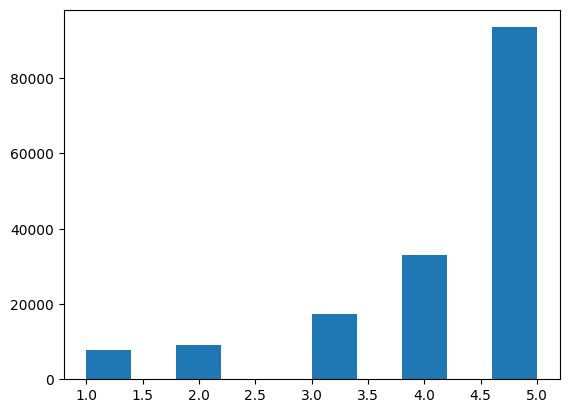

In [ ]:
plt.hist(baby['overall']) #amazon uses a 5 star system

In [ ]:
baby['y'] = baby['overall'] == 5

(array([67266.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 93526.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

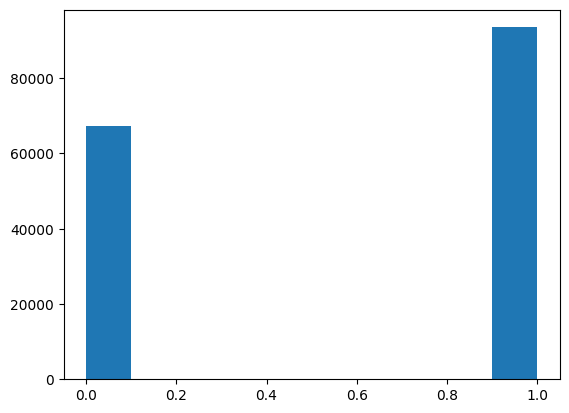

In [ ]:
plt.hist(baby['y'].map(int))

### Vectorizors

Most models cannot read text natively so we have to preprocess. This includes stripping punctuation, removing caps and counting words. A count vectorizor turns text data into a matrix where reach row represents a document and each column a word.

In [ ]:
sample_corpus = ['I think class is boring', 'CLASS IS BORING', 'CLASS,iS,boRing!!', 'potato']

In [ ]:
vectorizer = CountVectorizer(stop_words = 'english')

In [ ]:
sample_vectorizer = vectorizer.fit(sample_corpus)
output_data = sample_vectorizer.transform(sample_corpus)

In [ ]:
sample_vectorizer.get_feature_names_out()

array(['boring', 'class', 'potato', 'think'], dtype=object)

In [ ]:
output_data.todense()

matrix([[1, 1, 0, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 0]])

Let's strip out numbers and multiple repeated characters. So

hiiiiiii! becomes hi

In [ ]:
pattern = r'[0-9]'

baby['review_trim'] = baby['reviewText'].str.replace(r'\_', '', regex = True)
baby['reviews'] = baby['review_trim'].str.replace(r"(.)\1{1,}", r"\1", regex = True)

As with any model we split train and test

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(baby['reviews'], baby['y'])

We only train our vectorizer on the training data

In [ ]:
fit_vectorizer = vectorizer.fit(train_X)

In [ ]:
fit_vectorizer.get_feature_names_out()

array(['01', '010tg', '0186010', ..., 'zutano', 'zwipes', 'zz'],
      dtype=object)

In [ ]:
fit_vectorizer.vocabulary_.get('baby')

5149

In [ ]:
count_vec_data = fit_vectorizer.transform(train_X)

Count vectorizers on their own don't really tell us how important a word is within a dataset. So we need another step. TF-IDF or term frequency inverse document frequency tells us how common a word is while controlling for how often it shows in all the documents within the dataset

In [ ]:
tfidf_fit = TfidfTransformer().fit(count_vec_data)
feats = tfidf_fit.transform(count_vec_data)

Anytime we have multiple transformations we can chain them into a pipeline

In [ ]:
 pipe = Pipeline([('count', CountVectorizer(stop_words = 'english')), ('tfid', TfidfTransformer())])

In [ ]:
fit_pipe = pipe.fit(train_X)

In [ ]:
train_X_prep = fit_pipe.transform(train_X)
test_X_prep = fit_pipe.transform(test_X)

In [ ]:
test_X_prep

<40198x52397 sparse matrix of type '<class 'numpy.float64'>'
	with 1434936 stored elements in Compressed Sparse Row format>

We can fit a logistic regression predicting if the review will be positive or not. We use an L2 or ridge regression which adds a penalty to our coefficients to help with feature selection

In [ ]:
clf = LogisticRegression(tol=1e-2, penalty = 'l2', max_iter = 1000)
clf.fit(train_X_prep, train_y)
pred = clf.predict(test_X_prep)

Let's see how we did

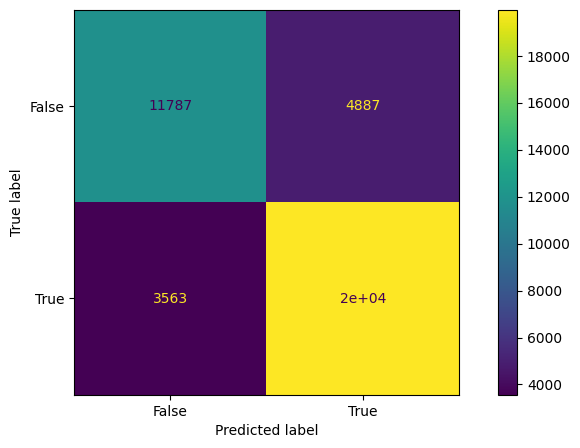

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(test_y, pred, ax=ax)

In [ ]:
roc_auc_score(test_y, pred)

0.7777233118601086

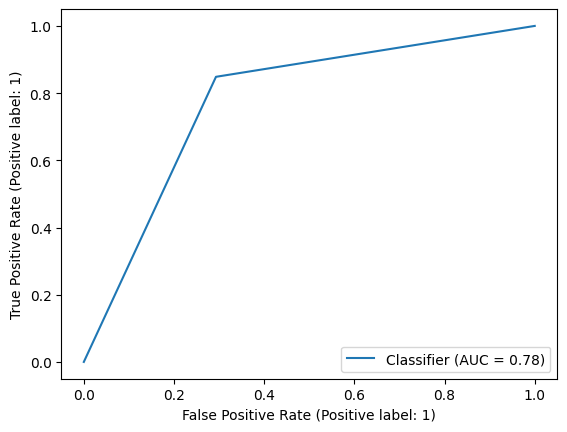

In [ ]:
RocCurveDisplay.from_predictions(test_y, pred)

We can look at the coefs to see the words associated with increased odds of bad or good scores.

In [ ]:
coefs = pd.DataFrame()
coefs['coef_value'] = clf.coef_[0]
coefs['abs_coef'] = np.abs(clf.coef_[0])

In [ ]:
vocab = pipe[0].vocabulary_

keys = list(vocab.keys())
values = list(vocab.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

In [ ]:
coefs['word'] = sorted_dict.keys()

In [ ]:
coefs.sort_values('abs_coef').tail(20)

,coef_value,abs_coef,word
14606,-5.020448,5.020448,disapointing
3384,5.144196,5.144196,amazing
38389,-5.166174,5.166174,returning
31496,-5.312844,5.312844,ok
38386,-5.317692,5.317692,return
21015,5.361901,5.361901,great
32335,-5.429166,5.429166,overal
20482,5.439142,5.439142,glad
38388,-5.458043,5.458043,returned
11124,-5.551400,5.551400,complaint


In [ ]:
bad = ['This stroller is awful and useless, I hate it']
good = ['This stroller is amazing, I love it so much']

In [ ]:
samples = bad+good

In [ ]:
sample_transform = pipe.transform(samples)

In [ ]:
clf.predict_proba(sample_transform)[:,1]

array([0.02443998, 0.99958888])

In [ ]:
clf.predict(sample_transform)

array([False,  True])

But what if we don't have labels. In that case we have two options. One is to use a sentiment lookup, basically certain words are coded as having positive or negative sentiment and the lookup tallies up the score based on their presence.

In [ ]:
small_baby = baby.sample(2000, random_state = 42)
train_small_X, test_small_X, train_small_y, test_small_y = train_test_split(small_baby['reviewText'], small_baby['y'])

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
baby_list = train_small_X.values.tolist()

In [ ]:
holder = []
for sentence in baby_list:
    holder.append(analyzer.polarity_scores(sentence))


In [ ]:
result_holder = pd.DataFrame(holder)

In [ ]:
result_holder['review']  = baby_list

In [ ]:
result_holder.head(5)

,neg,neu,pos,compound,review
0,0.072,0.748,0.180,0.8246,"its ok, a lot smaller than i thought (about 7&..."
1,0.196,0.804,0.000,-0.7239,The tread is difficult. Fully closed it's diff...
2,0.042,0.758,0.201,0.9422,"good buy, good price.Maybe if the middle compa..."
3,0.021,0.911,0.069,0.6257,"I wanted a new high chair for my daughter, who..."
4,0.000,0.819,0.181,0.9081,"I love the bright, happy colors of this bottle..."


In [ ]:
result_holder.sort_values('compound').tail(20)['review']

768     Like many moms, I am no novice at diaper bags....
685     Updated: July 12, 2014: I originally gave the ...
1327    I drive a small hatchback so this was the only...
226     I agree with the excellent reviews of this boo...
18      I purchased this bag back in January 2011 and ...
684     Just got this today so thought I would write a...
691     Things I love about this bag:- It doesn't look...
351     Received my daughter's Britax Advocate 70 car ...
438     I wanted a fancy colorful Baby Einstein jumper...
359     ***UPDATE*** My son and I took this on a a tes...
1030    I love this tub. We have used it for 8 months ...
346     I wanted a "cheap" seat for our second car, wh...
190     My daughter has loved this toy since the day s...
1312    We received this tub as a gift when our daught...
73      This Graco Pack `N Play is definitely a plaype...
869     My friend bought me this car seat from Amazon....
793     I was so excited to try this car seat!  The ot...
873     I had 

The other option is to use a pretrained model. These are models created on massive datasets. We can fine tune the model for our specific use case.

In [ ]:
from transformers import pipeline
from datasets import Dataset

# create pipeline for sentiment analysis
pretrain = pipeline('sentiment-analysis', model = 'distilbert-base-uncased-finetuned-sst-2-english')

In [ ]:
hf_predictions = pretrain.predict(train_small_X.str.slice(0,512).values.tolist())

In [ ]:
train_small_X_df = pd.DataFrame([train_small_X.str.slice(0,512), train_small_y.map(int)]).T
train_small_X_df.columns = ['reviewText', 'label']
test_small_X_df = pd.DataFrame([test_small_X.str.slice(0,512), test_small_y.map(int)]).T
test_small_X_df.columns = ['reviewText', 'label']

In [ ]:
pretrain_data =  Dataset.from_pandas(train_small_X_df)
pretest_data = Dataset.from_pandas(train_small_X_df)

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples['reviewText'], truncation=True)

tokenized_train = pretrain_data.map(preprocess_function)
tokenized_test = pretest_data.map(preprocess_function)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [ ]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
   output_dir = "/",
   learning_rate=2e-3,
   per_device_train_batch_size=64,
   per_device_eval_batch_size=64,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=24, training_loss=0.9025707244873047, metrics={'train_runtime': 1031.9796, 'train_samples_per_second': 1.454, 'train_steps_per_second': 0.023, 'total_flos': 53850067356768.0, 'train_loss': 0.9025707244873047, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

<ipython-input-60-60cdf6b82ba9>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.6820339560508728,
 'eval_accuracy': 0.5846666666666667,
 'eval_f1': 0.7379049221708035,
 'eval_runtime': 459.664,
 'eval_samples_per_second': 3.263,
 'eval_steps_per_second': 0.052,
 'epoch': 1.0}